# PERHITUNGAN JARAK 100 DATA SUARA BUKA/TUTUP DAN 1 DATA SUARA BARU MENGGUNAKAN DATA TIME WARPING

Pada tugas ini, data suara yang saya gunakan masih sama dengan tugas sebelumnya. keseluruhan suara saya simpan di folder PSD-audio-wav, yaitu data suara yang telah dikonvert ke ekstensi wav dan terdiri dari suara yang mengucapkan buka atau tutup. Di dalam nya terdaoat 3 folder lain, pertama terdapat folder 'Suara1' yang berisi 50 data rekaman suara saya. folder ini terdiri dari 25 suara buka dengan label 'Perekaman baru 1' sampai dengan 'Perekaman label 25' dan terdiri dari 25 suara tutup dengan label 'Perekaman suara 26' sampai dengan 'Perekaman baru 50'. Folder kedua yaitu 'Suara2" yang berisi 50 data suara teman saya. Folder ini terdiri dari 25 suara buka dengan label 'buka1' sampai dengan 'buka25' dan terdiri dari suara tutup dengan label 'tutup1' sampai dengan 'tutup25'. Ketiga ada folder 'suara-baru' yang terdiri dari 1 rekaman suara buka dengan label 'Perekaman baru 51'. 

## Import Library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io.wavfile as wav
import python_speech_features as psf

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import seaborn as sns


## Baca Data Suara

In [ ]:
base_path = "PSD-audio-wav"

dataset_info = []

folder1 = os.path.join(base_path, "Suara1")
files1 = sorted(os.listdir(folder1))
for i, f in enumerate(files1, start=1):
    label = "buka" if i <= 25 else "tutup"
    dataset_info.append([f, "Suara1", label])

folder2 = os.path.join(base_path, "Suara2")
files2 = sorted(os.listdir(folder2))
for f in files2:
    label = "buka" if f.lower().startswith("buka") else "tutup"
    dataset_info.append([f, "Suara2", label])

# Folder suara-baru
folder3 = os.path.join(base_path, "suara-baru")
files3 = sorted(os.listdir(folder3))
for f in files3:
    dataset_info.append([f, "suara-baru", "Tidak diketahui (Testing)"])

df_dataset = pd.DataFrame(dataset_info, columns=["Nama File", "Folder", "Label"])

print("Jumlah rekaman per folder:")
print(df_dataset["Folder"].value_counts())
df_dataset.head()


Jumlah rekaman per folder:
Folder
Suara1        50
Suara2        50
suara-baru     1
Name: count, dtype: int64


,Nama File,Folder,Label
0,Perekaman baru 1.wav,Suara1,buka
1,Perekaman baru 10.wav,Suara1,buka
2,Perekaman baru 11.wav,Suara1,buka
3,Perekaman baru 12.wav,Suara1,buka
4,Perekaman baru 13.wav,Suara1,buka


## Load Audio dan Normalisasi Sample Rate

In [ ]:
def load_audio(file_path, target_sr=16000, n_mfcc=13):
    sr, audio = wav.read(file_path)

    if len(audio.shape) == 2:
        audio = audio[:, 0]

    audio = audio / np.max(np.abs(audio))

    mfcc = psf.mfcc(audio, samplerate=sr, numcep=n_mfcc)

    return audio, mfcc, sr


In [ ]:
print("Preprocessing dilakukan saat ekstraksi MFCC.")


Preprocessing dilakukan saat ekstraksi MFCC.


## Visualisasi

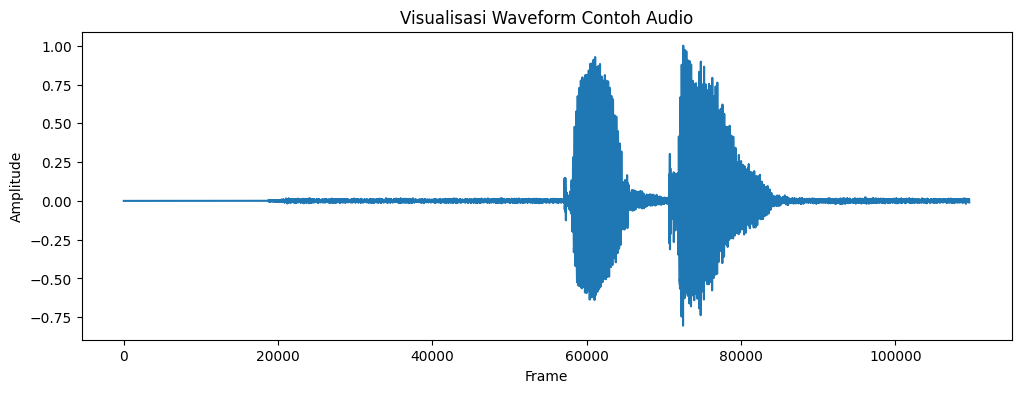

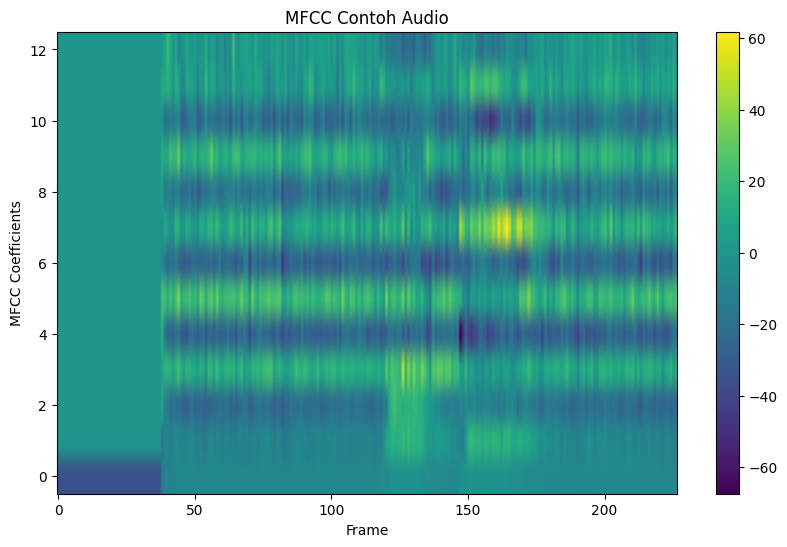

In [ ]:
example_path = os.path.join(folder1, files1[0])
audio_ex, mfcc_ex, sr_ex = load_audio(example_path)

plt.figure(figsize=(12, 4))
plt.plot(audio_ex)
plt.title("Visualisasi Waveform Contoh Audio")
plt.xlabel("Frame")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(mfcc_ex.T, aspect='auto', origin='lower')
plt.title("MFCC Contoh Audio")
plt.xlabel("Frame")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()


## Hitung jarak DTW dari 100 audio lama ke 1 audio baru

In [ ]:
testing_file = os.path.join(folder3, files3[0])
_, mfcc_test, _ = load_audio(testing_file)

jarak_hasil = []

for idx, row in df_dataset.iterrows():
    if row["Folder"] == "suara-baru":
        continue

    file_path = os.path.join(base_path, row["Folder"], row["Nama File"])
    _, mfcc_ref, _ = load_audio(file_path)

    # Hitung DTW
    dist, _ = fastdtw(mfcc_ref, mfcc_test, dist=euclidean)

    jarak_hasil.append([row["Nama File"], row["Folder"], row["Label"], dist])

df_jarak = pd.DataFrame(jarak_hasil, columns=["Nama File", "Folder", "Label", "Jarak DTW"])
df_jarak.head()


,Nama File,Folder,Label,Jarak DTW
0,Perekaman baru 1.wav,Suara1,buka,7694.813621
1,Perekaman baru 10.wav,Suara1,buka,7504.428669
2,Perekaman baru 11.wav,Suara1,buka,6015.100322
3,Perekaman baru 12.wav,Suara1,buka,7155.610085
4,Perekaman baru 13.wav,Suara1,buka,6911.236092


## 5 Audio Termirip

In [ ]:

df_top5 = df_jarak.sort_values(by="Jarak DTW").head(5)
print("5 Audio Paling Mirip:")
print(df_top5)


5 Audio Paling Mirip:
                Nama File  Folder Label    Jarak DTW
12  Perekaman baru 20.wav  Suara1  buka     0.000000
5   Perekaman baru 14.wav  Suara1  buka  5900.711901
11   Perekaman baru 2.wav  Suara1  buka  5948.022621
7   Perekaman baru 16.wav  Suara1  buka  5981.957009
6   Perekaman baru 15.wav  Suara1  buka  6002.769999


## Heatmap Visualisasi DTW

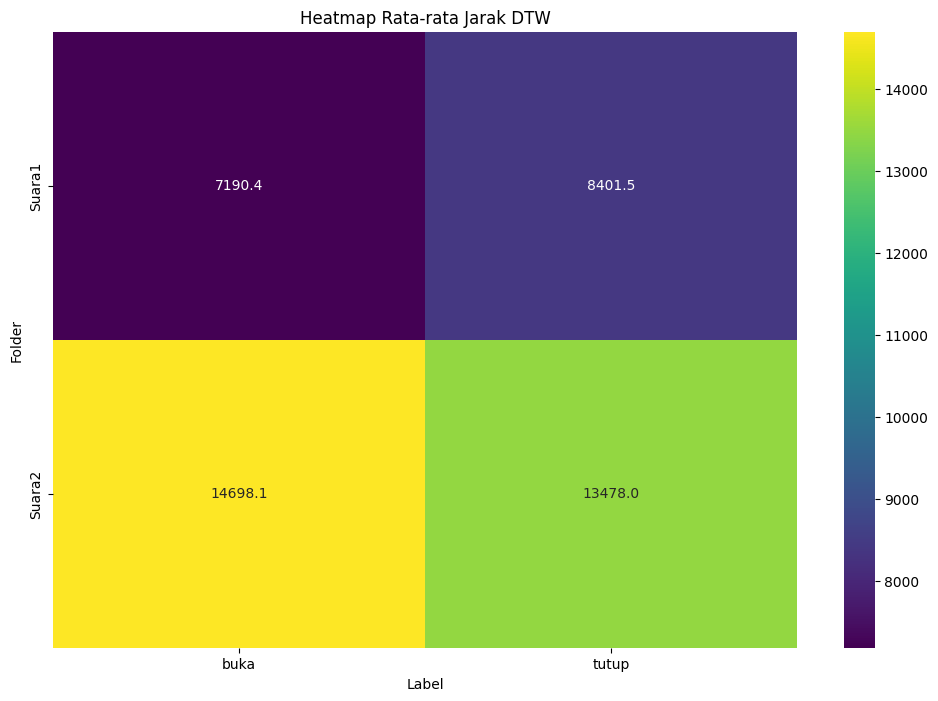

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_jarak.pivot_table(values="Jarak DTW",
                                 index="Folder",
                                 columns="Label",
                                 aggfunc="mean"),
            annot=True, fmt=".1f", cmap="viridis")

plt.title("Heatmap Rata-rata Jarak DTW")
plt.show()
